In [1]:

import fix_yahoo_finance as yf
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

from core.live_data_processor import LiveDataLoader
from core.model import Model

Using TensorFlow backend.


In [2]:


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
    
def denormalize_data():
    return 


In [3]:
if __name__ == '__main__':
    #  Setting pyplot fig size
    plt.rcParams['figure.figsize'] = [10, 8]    
    # Download gold price from yahoo finance
    gld_dataframe = yf.download(tickers="GLD", start="2000-1-1")
    # Display sample dataframe
    display(gld_dataframe.head(5))
    display(gld_dataframe.tail(5))

[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-09,123.260002,123.349998,123.029999,123.150002,123.150002,4648400
2019-04-10,123.220001,123.769997,123.190002,123.529999,123.529999,6344800
2019-04-11,122.540001,122.750000,121.790001,121.949997,121.949997,11694500
2019-04-12,121.959999,122.309998,121.800003,121.830002,121.830002,5272800
2019-04-15,121.199997,121.820000,121.099998,121.599998,121.599998,4252400


In [4]:

    data = LiveDataLoader(
        dataframe=gld_dataframe,
        split=0.8,
        cols=['Open', 'Close', 'Volume']
    )
    x, y = data.get_train_data(30, True)
    display_x_train = np.reshape(x, (-1, 3))
    display(pd.DataFrame(display_x_train).head(5))
    display_y_train = np.reshape(y, (-1, 1))
    display(pd.DataFrame(display_y_train).head(5))

,0,1,2
0,0.000000,0.000000,0.000000
1,0.001350,0.009013,0.945144
2,0.007202,0.012844,1.002003
3,0.010128,0.008337,-0.471095
4,0.011254,0.015097,0.018875


,0
0,-0.013054
1,-0.033940
2,-0.043575
3,-0.047460
4,-0.054529


In [5]:
    model = Model()
    model.build_model()
    model.model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[Model] Model Compiled
Time taken: 0:00:01.238071
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 29, 100)           41600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 29, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 29, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_____________________________________

In [6]:
    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil(((data.len_train - 30) / 32))
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=30,
            batch_size=32,
            normalise=True
        ),
        epochs=5,
        batch_size=32,
        steps_per_epoch=steps_per_epoch,
        save_dir='saved_models'
    )



[Model] Training Started
[Model] 5 epochs, 32 batch size, 90 batches per epoch
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
90/90 [==============================] - 18s 203ms/step - loss: 0.0020
Epoch 2/5
90/90 [==============================] - 16s 173ms/step - loss: 0.0012
Epoch 3/5
90/90 [==============================] - 19s 207ms/step - loss: 7.0257e-04
Epoch 4/5
90/90 [==============================] - 18s 200ms/step - loss: 5.6689e-04
Epoch 5/5
90/90 [==============================] - 21s 229ms/step - loss: 4.9277e-04
[Model] Training Completed. Model saved as saved_models\16042019-092015-e5.h5
Time taken: 0:01:34.842425


[Model] Predicting Point-by-Point...


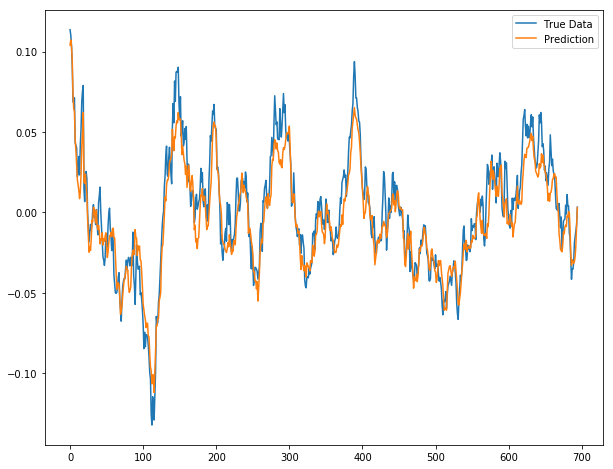

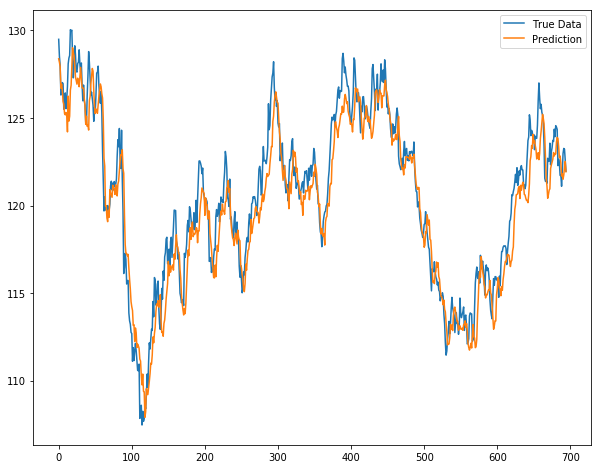

[Prediction] Correct 37.46 %
[Prediction] Mean entropy 26.836832
[Prediction] Max deviation 0.239554


In [7]:
    x_test, y_test = data.get_test_data(
    seq_len=30,
    normalise=True)
    
    _, y_test_normal = data.get_test_data(
                         seq_len=30,
                         normalise=False)

    predictions_p = model.predict_point_by_point(x_test)
    predictions_p_normal = data.denormailise_prediction(predictions_p)
    
    plot_results(predictions_p, y_test)
    plot_results(predictions_p_normal, y_test_normal)
    count = 0
    diff=[]
    for i in range(y_test.size):
        prediction = float(predictions_p[i])
        real = float(y_test[i][0])
        if real != 0 :
            diff.append(abs(prediction / real))
            if abs(1 - abs(prediction / real)) < 0.2 :
                count = count + 1
                
    diff = np.array(diff)
    # percentage of <5000 difference data in the whole testing data set
    percentage = float(count)/diff.size * 100
    print('[Prediction] Correct %.2f %%' % percentage)
    # display(pd.DataFrame(y_test))
    # display(pd.DataFrame(predictions_p))
    # predicted data that are below 3 difference
    mean_entropy = np.sum(abs(y_test-predictions_p))/len(y_test)

    max_deviation = np.max(abs(y_test-predictions_p))

    deviation = np.array(abs(y_test-predictions_p)).astype(np.float64)

    
    print('[Prediction] Mean entropy %f' % mean_entropy)
    print('[Prediction] Max deviation %f' % max_deviation)
    

    rmse = np.sqrt(np.sum(predictions_p - y_test)**2)